In [9]:
# 1) imports & device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import torchvision
import torchvision.transforms as transforms        # added

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


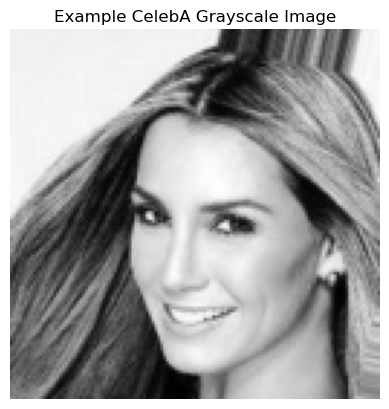

In [10]:
# 2) load CelebA grayscale dataset and plot example
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor()
])
celeb_train = torchvision.datasets.CelebA(
    root='./data', split='train', download=True, transform=transform
)
img, _ = celeb_train[0]
plt.imshow(img.squeeze(0), cmap='gray')
plt.title('Example CelebA Grayscale Image')
plt.axis('off')
plt.show()

In [11]:
# 3) Image dataset with random pixel masking + splits
class ImageDataset(Dataset):
    def __init__(self, base_ds, keep_frac=0.6):
        self.base_ds = base_ds
        self.keep_frac = keep_frac

    def __len__(self):
        return len(self.base_ds)

    def __getitem__(self, idx):
        img, _ = self.base_ds[idx]             # [3,H,W] tensor
        mask = torch.rand_like(img) < self.keep_frac
        img_in = img * mask.float()
        return img_in, img

# prepare train/val/test splits
full_train = ImageDataset(celeb_train, keep_frac=0.8)
limited_train = torch.utils.data.Subset(full_train, list(range(2500)))   # only first 2500 samples

train_size = int(0.8 * len(limited_train))  # 2000
val_size   = len(limited_train) - train_size  # 500
train_ds, val_ds = random_split(limited_train, [train_size, val_size])

celeb_test = torchvision.datasets.CelebA(
    root='./data', split='test', download=True, transform=transform
)
test_ds = torch.utils.data.Subset(ImageDataset(celeb_test, keep_frac=0.8), list(range(500)))  # only first 500 samples

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=16)
test_loader  = DataLoader(test_ds,  batch_size=16)

In [ ]:
# 4) CNN → output 4 channels for NIG parameters
class SingleConv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(SingleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.InstanceNorm2d(ch_out),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.InstanceNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.InstanceNorm2d(ch_out),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class ResidualBlock_mod(nn.Module):
    # ReflectionPad and InstanceNorm
    def __init__(self, ch_in):
        super(ResidualBlock_mod, self).__init__()

        self.block = nn.Sequential(
            # Pads the input tensor using the reflection of the input boundary
            nn.ReflectionPad2d(1),
            nn.Conv2d(ch_in, ch_in, 3),
            nn.InstanceNorm2d(ch_in),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(ch_in, ch_in, 3),
            nn.InstanceNorm2d(ch_in),
        )
        self.relu = nn.Sequential(nn.ReLU(inplace=True))

    def forward(self, x):
        y = x + self.block(x)
        y1 = self.relu(y)
        return y1
    
class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out, up_conv):
        super(UpConvBlock, self).__init__()

        if up_conv:
            self.up = nn.Sequential(
                nn.ConvTranspose2d(
                    ch_in, ch_out, kernel_size=3, stride=2, padding=1, output_padding=1
                ),
                nn.InstanceNorm2d(ch_out),
                nn.ReLU(inplace=True),
            )

        else:
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
                nn.InstanceNorm2d(ch_out),
                nn.ReLU(inplace=True),
            )

    def forward(self, x):
        x = self.up(x)
        return x

class CNN_NIG(nn.Module):
    def __init__(self):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        up_conv = True

        self.conv1 = ConvBlock(ch_in=1, ch_out=4)
        self.conv1_extra = SingleConv(ch_in=4, ch_out=4)
        self.conv2 = ConvBlock(ch_in=4, ch_out=8)
        self.conv3 = ConvBlock(ch_in=8, ch_out=16)
        self.conv4 = ConvBlock(ch_in=16, ch_out=32)

        self.resnet = ResidualBlock_mod(ch_in=32)
        # self.resnet = ResidualBlock(ch_in=1024)

        self.up4 = UpConvBlock(ch_in=32, ch_out=16, up_conv=up_conv)
        self.up_conv4 = ConvBlock(ch_in=32, ch_out=16)
        self.up3 = UpConvBlock(ch_in=16, ch_out=8, up_conv=up_conv)
        self.up_conv3 = ConvBlock(ch_in=16, ch_out=8)
        self.up2 = UpConvBlock(ch_in=8, ch_out=4, up_conv=up_conv)
        self.up_conv2 = ConvBlock(ch_in=8, ch_out=8)

        self.final_conv = nn.Sequential(ConvBlock(ch_in=8, ch_out=4),
                                        nn.Conv2d(4, 4, kernel_size=1, stride=1, padding=0))

    def forward(self, x):
        # encoding path
        e1 = self.conv1(x)
        e1 = self.conv1_extra(e1)

        e2 = self.maxpool(e1)
        e2 = self.conv2(e2)

        e3 = self.maxpool(e2)
        e3 = self.conv3(e3)

        e4 = self.maxpool(e3)
        e4 = self.conv4(e4)

        # ResNet Blocks
        r1 = self.resnet(e4)
        r2 = self.resnet(r1)
        r3 = self.resnet(r2)
        r4 = self.resnet(r3)

        d4 = self.up4(r4)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.up_conv4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.up_conv3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.up_conv2(d2)

        d1 = self.final_conv(d2)

        # split channels and apply softplus to ν, α, β
        gamma = x + d1[:, 0:1] # residual connection
        nu    = F.softplus(d1[:, 1:2]) + 1e-6
        alpha = F.softplus(d1[:, 2:3]) + 1.0 + 1e-6
        beta  = F.softplus(d1[:, 3:4]) + 1e-6

        return torch.cat([gamma, nu, alpha, beta], dim=1)

In [47]:
# 5) NIG loss + regularization
import torch.special as special

def nig_nll(y, gamma, nu, alpha, beta):
    """
    y:   true values [...,H,W]
    gamma,nu,alpha,beta: predictions, same shape
    returns per-pixel NLL
    """
    omega = 2.*beta*(1.+nu)
    # term1 = 0.5*log(pi/nu)
    term1 = 0.5*(torch.log(torch.tensor(np.pi, device=y.device)) - torch.log(nu))
    # term2 = -alpha*log(Omega)
    term2 = -alpha * torch.log(omega)
    # term3 = (alpha+0.5)*log((y-gamma)^2 * nu + Omega)
    term3 = (alpha + 0.5) * torch.log((y-gamma)**2 * nu + omega)
    # term4 = log Gamma(alpha) - log Gamma(alpha+0.5)
    term4 = special.gammaln(alpha) - special.gammaln(alpha + 0.5)
    return term1 + term2 + term3 + term4

def nig_reg(y, gamma, nu, alpha, beta):
    """regularizer: |y-gamma| * (2 nu + alpha)"""
    return torch.abs(y-gamma) * (2.*nu + alpha)

def nig_loss(pred, target, lam=1e-3):
    """
    pred: [B,4,H,W]: channels are [gamma, nu, alpha, beta]
    target: [B,1,H,W]
    """
    gamma, nu, alpha, beta = torch.chunk(pred,4,dim=1)
    y = target
    nll = nig_nll(y, gamma, nu, alpha, beta).mean()
    reg = nig_reg(y, gamma, nu, alpha, beta).mean()
    return nll + lam*reg

In [ ]:
# 6) train PD model (image reconstruction) and plot per‐batch loss
batch_losses = []

PD_model = CNN_NIG().to(device)
pd_optimizer = optim.Adam(PD_model.parameters(), lr=5e-3)

best_val = float('inf')
for epoch in range(1, 10):
    PD_model.train()
    tot_loss = 0
    for pd_in, pd_gt in tqdm(train_loader, desc=f"Epoch {epoch}"):
        pd_in, pd_gt = pd_in.to(device), pd_gt.to(device)
        pred = PD_model(pd_in)
        smooth_l1_loss = nn.SmoothL1Loss()(pred[:, [0]], pd_gt)
        nig_loss_ = nig_loss(pred, pd_gt, lam=1e-1)
        loss = smooth_l1_loss + nig_loss_ / 10.0
        pd_optimizer.zero_grad()
        loss.backward()
        pd_optimizer.step()

        l = loss.item()
        batch_losses.append(l)
        tot_loss += l

    print(f"  Train loss: {tot_loss/len(train_loader):.4f}")
    print(f"  Smooth L1 loss: {smooth_l1_loss.item():.4f}")
    print(f"  NIG loss: {nig_loss_.item() / 10.0:.4f}")

    # validation & checkpoint as before…
    PD_model.eval()
    with torch.no_grad():
        vloss = 0
        for pd_in, pd_gt in val_loader:
            pd_in, pd_gt = pd_in.to(device), pd_gt.to(device)
            vloss += nn.SmoothL1Loss()(PD_model(pd_in)[:, [0]], pd_gt).item()
    vloss /= len(val_loader)
    print(f"  Val   loss: {vloss:.4f}")

    torch.save(PD_model.state_dict(), f"pd_epoch{epoch}.pth")
    if vloss < best_val:
        best_val = vloss
        torch.save(PD_model.state_dict(), "pd_best.pth")
        print("  Saved best model")

Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


  Train loss: 0.0591
  Smooth L1 loss: 0.0034
  NIG loss: -0.0206
  Val   loss: 0.0032
  Saved best model


Epoch 2: 100%|██████████| 125/125 [00:59<00:00,  2.11it/s]


  Train loss: -0.0798
  Smooth L1 loss: 0.0014
  NIG loss: -0.1390
  Val   loss: 0.0021
  Saved best model


Epoch 3: 100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


  Train loss: -0.1715
  Smooth L1 loss: 0.0016
  NIG loss: -0.2113
  Val   loss: 0.0018
  Saved best model


Epoch 4: 100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


  Train loss: -0.2272
  Smooth L1 loss: 0.0022
  NIG loss: -0.2550
  Val   loss: 0.0019


Epoch 5: 100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


  Train loss: -0.2626
  Smooth L1 loss: 0.0020
  NIG loss: -0.2907
  Val   loss: 0.0021


Epoch 6: 100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


  Train loss: -0.2763
  Smooth L1 loss: 0.0022
  NIG loss: -0.2938
  Val   loss: 0.0020


Epoch 7: 100%|██████████| 125/125 [00:59<00:00,  2.11it/s]


  Train loss: -0.2977
  Smooth L1 loss: 0.0022
  NIG loss: -0.3095
  Val   loss: 0.0020


Epoch 8: 100%|██████████| 125/125 [00:58<00:00,  2.14it/s]


  Train loss: -0.3082
  Smooth L1 loss: 0.0025
  NIG loss: -0.3199
  Val   loss: 0.0022


Epoch 9: 100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


  Train loss: -0.3037
  Smooth L1 loss: 0.0028
  NIG loss: -0.3184
  Val   loss: 0.0023


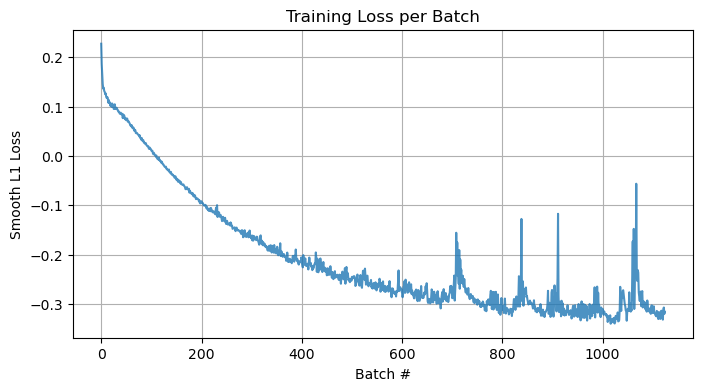

In [50]:
# plot the loss curve (per batch)
plt.figure(figsize=(8,4))
plt.plot(batch_losses, '-', alpha=0.8)
plt.xlabel('Batch #')
plt.ylabel('Smooth L1 Loss')
plt.title('Training Loss per Batch')
plt.grid(True)
plt.show()

In [51]:
# Test the PD model
print("Loading best PD model for testing...")
PD_model.load_state_dict(torch.load("pd_best.pth"))
print("Loaded best model.")
PD_model.eval()
test_loss = 0
with torch.no_grad():
    for pd_in, pd_gt in test_loader:
        pd_in, pd_gt = pd_in.to(device), pd_gt.to(device)
        pred = PD_model(pd_in)
        loss = nn.SmoothL1Loss()(pred[:, [0], ...], pd_gt)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f"Test loss: {test_loss:.4f}")

Loading best PD model for testing...
Loaded best model.
Test loss: 0.0017


Predicted shape: torch.Size([16, 4, 128, 128])
Ground truth shape: torch.Size([16, 1, 128, 128])
Input shape: torch.Size([16, 1, 128, 128])
L1 error (mean absolute difference): 0.039923016
Mean relative error: 0.24731564814451795
Epistemic uncertainty mean: 0.0014996484 max: 0.05475985
Aleatoric uncertainty mean: 0.0033330142 max: 0.07830457
Total uncertainty mean: 0.0048326626 max: 0.13306442


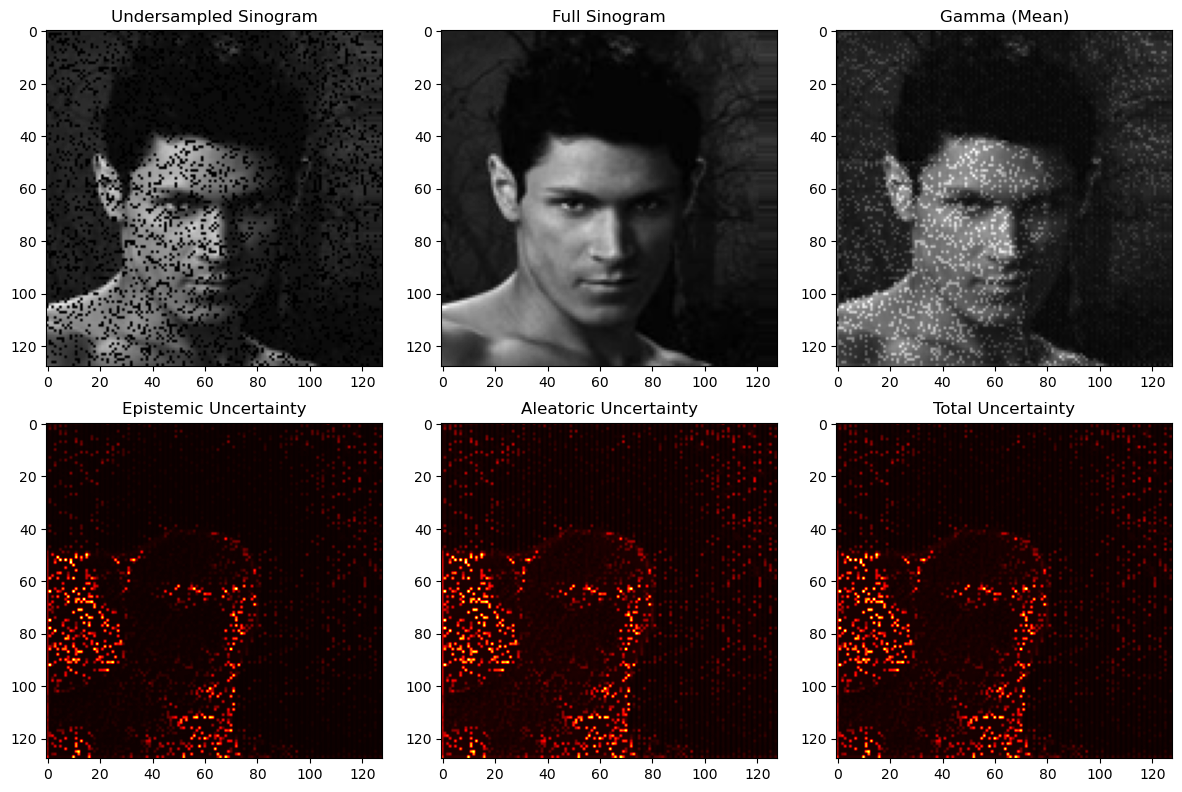

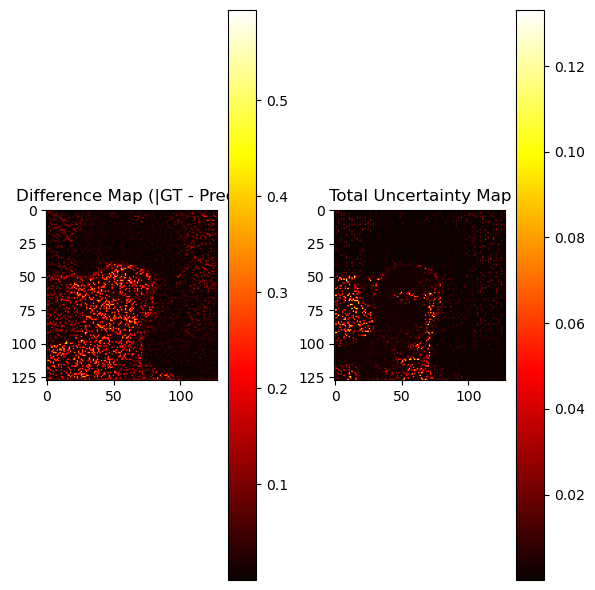

Correlation between gamma and ground truth: 0.9206307566626253
Correlation between total uncertainty and ground truth: -0.004304431013182613


In [58]:
# Plot example results with epistemic and aleatoric uncertainty maps
# note: epistemic = beta / nu(alpha - 1), aleatoric = beta/(alpha - 1)
def plot_results(pd_in, pd_gt, pred):
    # Note: pd_in and gt are expected to be [1,H,W] tensors,
    # and pred is expected to be [4,H,W] tensor with channels
    # [gamma, nu, alpha, beta]
    gamma, nu, alpha, beta = torch.chunk(pred, 4, dim=0)
    # convert to numpy for plotting
    pd_in_np = pd_in.cpu().numpy()[0]
    pd_gt_np = pd_gt.cpu().numpy()[0]
    gamma_np = gamma.cpu().numpy()[0]
    nu_np = nu.cpu().numpy()[0]
    alpha_np = alpha.cpu().numpy()[0]
    beta_np = beta.cpu().numpy()[0]

    # # Print the mean and std of each channel
    # print("Gamma mean:", gamma_np.mean(), "std:", gamma_np.std())
    # print("Nu mean:", nu_np.mean(), "std:", nu_np.std())
    # print("Alpha mean:", alpha_np.mean(), "std:", alpha_np.std())
    # print("Beta mean:", beta_np.mean(), "std:", beta_np.std())

    # # Print min, max, mean of input, gt, and gamma
    # print("Input min:", pd_in_np.min(), "max:", pd_in_np.max(), "mean:", pd_in_np.mean())
    # print("Ground truth min:", pd_gt_np.min(), "max:", pd_gt_np.max(), "mean:", pd_gt_np.mean())
    # print("Gamma min:", gamma_np.min(), "max:", gamma_np.max(), "mean:", gamma_np.mean())

    # epistemic uncertainty
    epistemic_uncertainty = beta_np / (nu_np * (alpha_np - 1))
    # aleatoric uncertainty
    aleatoric_uncertainty = beta_np / (alpha_np - 1)

    # Print L1 error
    l1_error = np.abs(pd_gt_np - gamma_np).mean()
    print("L1 error (mean absolute difference):", l1_error)

    # Print mean relative error
    mean_relative_error = np.abs(pd_gt_np - gamma_np).mean() / (pd_gt_np.mean() + 1e-6)
    print("Mean relative error:", mean_relative_error)

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(pd_in_np, cmap='gray')
    plt.title('Undersampled Sinogram')
    
    plt.subplot(2, 3, 2)
    plt.imshow(pd_gt_np, cmap='gray')
    plt.title('Full Sinogram')

    plt.subplot(2, 3, 3)
    plt.imshow(gamma_np, cmap='gray')
    plt.title('Gamma (Mean)')

    plt.subplot(2, 3, 4)
    plt.imshow(epistemic_uncertainty, cmap='hot', vmin=0, vmax=epistemic_uncertainty.max())
    plt.title('Epistemic Uncertainty')

    plt.subplot(2, 3, 5)
    plt.imshow(aleatoric_uncertainty, cmap='hot', vmin=0, vmax=aleatoric_uncertainty.max())
    plt.title('Aleatoric Uncertainty')

    plt.subplot(2, 3, 6)
    plt.imshow(aleatoric_uncertainty + epistemic_uncertainty, cmap='hot', vmin=0, vmax=(aleatoric_uncertainty + epistemic_uncertainty).max())
    plt.title('Total Uncertainty')

    print("Epistemic uncertainty mean:", epistemic_uncertainty.mean(), "max:", epistemic_uncertainty.max())
    print("Aleatoric uncertainty mean:", aleatoric_uncertainty.mean(), "max:", aleatoric_uncertainty.max())
    print("Total uncertainty mean:", (aleatoric_uncertainty + epistemic_uncertainty).mean(), "max:", (aleatoric_uncertainty + epistemic_uncertainty).max())

    plt.tight_layout()
    plt.show()

    # Plot the difference map and the total uncertainty map
    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(np.abs(pd_gt_np - gamma_np), cmap='hot')
    plt.title('Difference Map (|GT - Pred|)')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(epistemic_uncertainty + aleatoric_uncertainty, cmap='hot')
    plt.title('Total Uncertainty Map')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    # Calculate correlation between gamma and ground truth
    correlation = np.corrcoef(pd_gt_np.flatten(), gamma_np.flatten())[0, 1]
    print("Correlation between gamma and ground truth:", correlation)

    # Calculate correlation between total uncertainty and ground truth
    total_uncertainty = epistemic_uncertainty + aleatoric_uncertainty
    uncertainty_correlation = np.corrcoef(pd_gt_np.flatten(), total_uncertainty.flatten())[0, 1]
    print("Correlation between total uncertainty and ground truth:", uncertainty_correlation)

# Test on a single batch
pd_in, pd_gt = next(iter(train_loader))
PD_model.eval()
with torch.no_grad():
    pred = PD_model(pd_in.to(device))
    print("Predicted shape:", pred.shape)
    print("Ground truth shape:", pd_gt.shape)
    print("Input shape:", pd_in.shape)
    plot_results(pd_in[0], pd_gt[0], pred[0].cpu())